# **<center><font color='#DC8665' font-weight = 'bold'>Decision tree classification</font></center>**

## **library import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## **class Node**

In [2]:
class Node():
    def __init__(self, split_feature_index = None, split_treshhold = None, left_subtree = None,
                 right_subtree = None, node_information_gain = None, leaf_node_value = None):
        '''This class is simply a collection of data that the top of the decision tree should store.'''

        # Для внутренних вершин, содержащих предикат
        self.split_feature_index = split_feature_index
        self.split_treshhold = split_treshhold
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.node_information_gain = node_information_gain

        # Для листовых вершин, содержащих лишь значение
        self.leaf_node_value = leaf_node_value

## **class Decision_tree_classifier**

In [3]:
class Decision_tree_classifier():
    def __init__(self, node_min_samples_quant = 2, max_depth = 2):
        '''This is the model class for decision tree classification'''

        self._node_min_samples_quant = node_min_samples_quant
        self._max_depth = max_depth

        self._root = None
    
    def fit(self, X, Y):
        '''This function we need for training the model on the training set'''

        dataset = np.concatenate((X, Y), axis = 1, dtype = object)
        self._root = self._build_tree(dataset)
    
    def _build_tree(self, dataset, current_depth = 0):
        '''This function we need for building а decision tree'''
        X = dataset[:, :-1]
        Y = dataset[:, -1]
        
        dataset_rows_quant, dataset_features_quant = X.shape

        if dataset_rows_quant >= self._node_min_samples_quant and current_depth <= self._max_depth:
            best_split_values = self._get_best_split(dataset, dataset_features_quant)

            if best_split_values["node_information_gain"] > 0:
                left_subtree = self._build_tree(best_split_values["dataset_left_split"], current_depth + 1)
                right_subtree = self._build_tree(best_split_values["dataset_right_split"], current_depth + 1)

                return Node(best_split_values["split_feature_index"], best_split_values["split_treshhold"],
                            left_subtree, right_subtree, best_split_values["node_information_gain"])
        
        leaf_node_value = self._calculate_leaf_node_value(Y)

        return Node(leaf_node_value = leaf_node_value)

    def _get_best_split(self, dataset, dataset_features_quant):
        '''This function finds and makes the best split'''

        max_information_gain = -float("inf")
        best_split_values = {}

        for current_split_feature_idx in range(dataset_features_quant):
            possible_treshholds = np.unique(dataset[:, current_split_feature_idx])

            for current_split_treshhold in possible_treshholds:
                dataset_left_split, dataset_right_split = self._make_split(dataset, current_split_feature_idx,
                                                                           current_split_treshhold)

                if len(dataset_left_split) > 0 and len(dataset_right_split) > 0:
                    dataset_targets = dataset[:, -1]
                    dataset_left_split_targets = dataset_left_split[:, -1]
                    dataset_right_split_targets = dataset_right_split[:, -1]

                    current_information_gain = self._calculate_information_gain(dataset_targets,
                                                                                dataset_left_split_targets,
                                                                                dataset_right_split_targets)

                    if current_information_gain > max_information_gain:
                        best_split_values["split_feature_index"] = current_split_feature_idx
                        best_split_values["split_treshhold"] = current_split_treshhold
                        best_split_values["dataset_left_split"] = dataset_left_split
                        best_split_values["dataset_right_split"] = dataset_right_split
                        best_split_values["node_information_gain"] = current_information_gain
                        max_information_gain = current_information_gain
        
        return best_split_values

    def _make_split(self, dataset, dataset_split_feature_index, dataset_split_treshhold):
        '''This function produces the best sample split'''
        dataset_left_split = np.array([row for row in dataset if row[dataset_split_feature_index] <= dataset_split_treshhold])
        dataset_right_split = np.array([row for row in dataset if row[dataset_split_feature_index] > dataset_split_treshhold])

        return dataset_left_split, dataset_right_split
    
    def _calculate_information_gain(self, dataset_targets, dataset_left_split_targets, dataset_right_split_targets):
        '''This function calculates the difference between the impurity of the parent
        node and the sum of the impurity of the child nodes'''

        card_dataset_left_split_targets = len(dataset_left_split_targets)
        card_dataset_right_split_targets = len(dataset_right_split_targets)
        card_dataset_targets = len(dataset_targets)

        dataset_left_split_targets_entropy = self._calculate_entropy(dataset_left_split_targets)
        dataset_right_split_targets_entropy = self._calculate_entropy(dataset_right_split_targets)
        dataset_targets_entropy = self._calculate_entropy(dataset_targets)

        dataset_impurity = card_dataset_targets * dataset_targets_entropy
        split_impurity = card_dataset_left_split_targets * dataset_left_split_targets_entropy + \
                         card_dataset_right_split_targets * dataset_right_split_targets_entropy

        information_gain = dataset_impurity - split_impurity

        return information_gain
    
    def _calculate_entropy(self, data):
        '''This function calculates the entropy of the data to calculate the impurity'''

        data_classes = np.unique(data)
        data_entropy = 0

        for current_class in data_classes:
            current_class_objects_quant = len(data[data == current_class])
            p_current_class = current_class_objects_quant / len(data)
            data_entropy += -p_current_class * np.log2(p_current_class)

        return data_entropy

    def _calculate_leaf_node_value(self, dataset_targets):
        '''This function calculates the value that will be contained in the node if it is a leaf'''

        dataset_targets = list(dataset_targets)

        return max(dataset_targets, key = dataset_targets.count)

    def predict(self, data):
        '''This function predicts the values ​​(class labels) for the sample that was passed as an argument'''

        predictions = np.array([self._make_prediction(data_sample, self._root) for data_sample in data])

        return predictions

    def _make_prediction(self, sample, current_node):
        '''This function predicts a value (class label) for a particular sample object'''

        if current_node.leaf_node_value != None:
            return current_node.leaf_node_value
        else:
            feature_value = sample[current_node.split_feature_index]

            if feature_value <= current_node.split_treshhold:
                return self._make_prediction(sample, current_node.left_subtree)
            else:
                return self._make_prediction(sample, current_node.right_subtree)

## **initialize input data**

In [4]:
df = pd.read_csv("D://ADMP_Anastasia/machine_learning/datasets/dataset_for_decision_tree_classification.csv")
df

,x_1,x_2,y
0,2.523520,0.940873,1
1,9.018654,7.243306,2
2,8.852692,7.414476,2
3,2.846260,3.127090,1
4,7.774537,3.966554,2
...,...,...,...
437,6.576789,0.455548,1
438,3.613587,9.932009,0
439,1.818167,7.919254,0
440,2.830775,1.820310,1


In [5]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/3, random_state = 42)

X_test_len = len(X_test)
Y_test_len = len(Y_test)

## **сreating and training decision tree classifier model on our dataset**

In [7]:
model = Decision_tree_classifier(node_min_samples_quant=4, max_depth=4)
model.fit(X_train, Y_train)

## **making predictions**

In [8]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(-1, 1)
Y_pred_len = len(Y_pred)

## **displaying a graph with a test sample, true targets and model predictions**

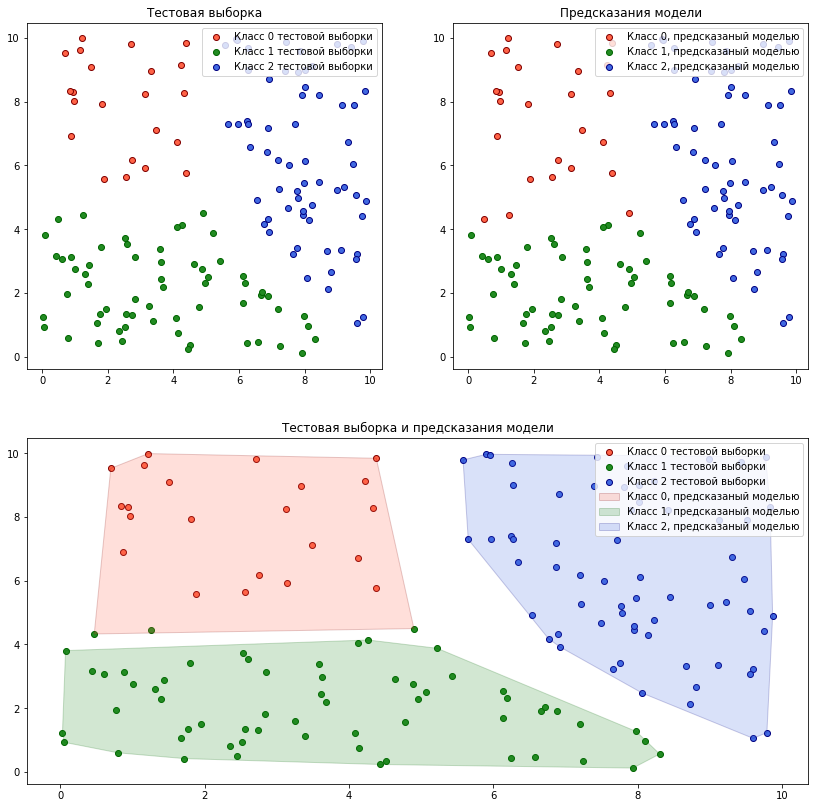

In [9]:
test_class_0_graph_x_1_values = []
test_class_0_graph_x_2_values = []

test_class_1_graph_x_1_values = []
test_class_1_graph_x_2_values = []

test_class_2_graph_x_1_values = []
test_class_2_graph_x_2_values = []

for i in range(Y_test_len):
    if Y_test[i] == 0:
        test_class_0_graph_x_1_values.append(X_test[i][0])
        test_class_0_graph_x_2_values.append(X_test[i][1])
        continue
    if Y_test[i] == 1:
        test_class_1_graph_x_1_values.append(X_test[i][0])
        test_class_1_graph_x_2_values.append(X_test[i][1])
        continue
    if Y_test[i] == 2:
        test_class_2_graph_x_1_values.append(X_test[i][0])
        test_class_2_graph_x_2_values.append(X_test[i][1])

pred_class_0_graph_x_1_values = []
pred_class_0_graph_x_2_values = []

pred_class_1_graph_x_1_values = []
pred_class_1_graph_x_2_values = []

pred_class_2_graph_x_1_values = []
pred_class_2_graph_x_2_values = []

for i in range(Y_pred_len):
    if Y_pred[i] == 0:
        pred_class_0_graph_x_1_values.append(X_test[i][0])
        pred_class_0_graph_x_2_values.append(X_test[i][1])
        continue
    if Y_test[i] == 1:
        pred_class_1_graph_x_1_values.append(X_test[i][0])
        pred_class_1_graph_x_2_values.append(X_test[i][1])
        continue
    if Y_test[i] == 2:
        pred_class_2_graph_x_1_values.append(X_test[i][0])
        pred_class_2_graph_x_2_values.append(X_test[i][1])

figure = plt.figure()

ax_1 = plt.subplot(221)
ax_2 = plt.subplot(222)
ax_3 = plt.subplot(212)

figure.set_figwidth(14)
figure.set_figheight(14)

ax_1.set_title('Тестовая выборка')
ax_1.scatter(test_class_0_graph_x_1_values, test_class_0_graph_x_2_values, color = "tomato",
           edgecolors='maroon', label = "Класс 0 тестовой выборки")
ax_1.scatter(test_class_1_graph_x_1_values, test_class_1_graph_x_2_values, color = "forestgreen",
           edgecolors='darkgreen', label = "Класс 1 тестовой выборки")
ax_1.scatter(test_class_2_graph_x_1_values, test_class_2_graph_x_2_values, color = "royalblue",
           edgecolors='navy', label = "Класс 2 тестовой выборки")

ax_1.legend(loc = 'upper right')

ax_2.set_title('Предсказания модели')
ax_2.scatter(pred_class_0_graph_x_1_values, pred_class_0_graph_x_2_values, color = "tomato",
           edgecolors='maroon', label = "Класс 0, предсказаный моделью")
ax_2.scatter(pred_class_1_graph_x_1_values, pred_class_1_graph_x_2_values, color = "forestgreen",
           edgecolors='darkgreen', label = "Класс 1, предсказаный моделью")
ax_2.scatter(pred_class_2_graph_x_1_values, pred_class_2_graph_x_2_values, color = "royalblue",
           edgecolors='navy', label = "Класс 2, предсказаный моделью")

ax_2.legend(loc = 'upper right')

ax_3.set_title('Тестовая выборка и предсказания модели')
ax_3.scatter(test_class_0_graph_x_1_values, test_class_0_graph_x_2_values, color = "tomato",
           edgecolors='maroon', label = "Класс 0 тестовой выборки")
ax_3.scatter(test_class_1_graph_x_1_values, test_class_1_graph_x_2_values, color = "forestgreen",
           edgecolors='darkgreen', label = "Класс 1 тестовой выборки")
ax_3.scatter(test_class_2_graph_x_1_values, test_class_2_graph_x_2_values, color = "royalblue",
           edgecolors='navy', label = "Класс 2 тестовой выборки")

pred_class_0_graph_x_1_x_2_values = np.c_[pred_class_0_graph_x_1_values, pred_class_0_graph_x_2_values]
pred_class_1_graph_x_1_x_2_values = np.c_[pred_class_1_graph_x_1_values, pred_class_1_graph_x_2_values]
pred_class_2_graph_x_1_x_2_values = np.c_[pred_class_2_graph_x_1_values, pred_class_2_graph_x_2_values]

pred_class_0_hull = ConvexHull(pred_class_0_graph_x_1_x_2_values)
pred_class_1_hull = ConvexHull(pred_class_1_graph_x_1_x_2_values)
pred_class_2_hull = ConvexHull(pred_class_2_graph_x_1_x_2_values)
pred_class_0_polygon = plt.Polygon(pred_class_0_graph_x_1_x_2_values[pred_class_0_hull.vertices,:],
                                   ec = "maroon", fc = "tomato", alpha=0.2, label = "Класс 0, предсказаный моделью")
pred_class_1_polygon = plt.Polygon(pred_class_1_graph_x_1_x_2_values[pred_class_1_hull.vertices,:],
                                   ec = "darkgreen", fc = "forestgreen", alpha=0.2, label = "Класс 1, предсказаный моделью")
pred_class_2_polygon = plt.Polygon(pred_class_2_graph_x_1_x_2_values[pred_class_2_hull.vertices,:],
                                   ec = "navy", fc = "royalblue", alpha=0.2, label = "Класс 2, предсказаный моделью")

ax_3.add_patch(pred_class_0_polygon)
ax_3.add_patch(pred_class_1_polygon)
ax_3.add_patch(pred_class_2_polygon)

ax_3.legend(loc = 'upper right')

plt.show()

## **displaying accuracy score of our predictions**

In [10]:
accuracy_score_value = accuracy_score(Y_test, Y_pred)
accuracy_score_value

0.9662162162162162

## **displaying a table with test data and targets**

In [11]:
test_df = pd.DataFrame(np.concatenate((X_test, Y_test), axis = 1, dtype = object),
             columns = ["x_1", "x_2", "y"])
test_df

,x_1,x_2,y
0,1.881904,5.564231,0
1,1.251147,4.434491,1
2,9.515421,7.91045,2
3,6.263766,9.677166,2
4,5.650935,7.290459,2
...,...,...,...
143,6.266334,7.303607,2
144,2.528623,3.729789,1
145,7.651741,3.22303,2
146,0.700648,9.519437,0


## **displaying a table with test data and our model predictions**

In [12]:
test_df = pd.DataFrame(np.concatenate((X_test, Y_pred), axis = 1, dtype = object),
             columns = ["x_1", "x_2", "y"])
test_df

,x_1,x_2,y
0,1.881904,5.564231,0
1,1.251147,4.434491,0
2,9.515421,7.91045,2
3,6.263766,9.677166,2
4,5.650935,7.290459,2
...,...,...,...
143,6.266334,7.303607,2
144,2.528623,3.729789,1
145,7.651741,3.22303,2
146,0.700648,9.519437,0
